In [1]:
# Fragrantica perfume review clasifier (LSTM with stopword removed)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn.model_selection import train_test_split
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Model Name
MODEL_NAME = 'lstm_with_stopword_removed_02'

# HyperParameters
PAD_LEN = 200
NUM_WORDS = 1000
EMBEDDING = 100
BATCH_SIZE = 128


74779
74779


In [ ]:
data = pd.read_csv('../dataset/dataset_210626_215600.csv')

X_data = data['stopwords_removed']
y_data = data['label']

print(len(X_data))
print(len(y_data))

##### label 의 빈도수 확인

C:\tools\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

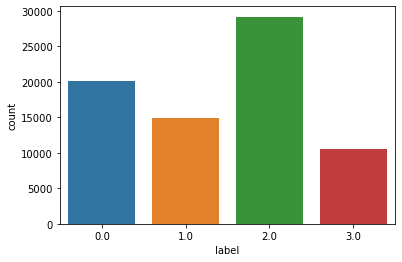

In [4]:
sns.countplot(y_data)

##### 토큰화 및 인덱스 부여

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

print(X_data[0])
print(len(sequences[0]))

['got', 'sample', 'today', 'year', 'old', 'daughter', 'thought', 'smelling', 'sprayed', 'card', 'rotten', 'fish', 'nearly', 'threw', 'immediately', 'however', 'later', 'evening', 'decided', 'give', 'fair', 'trial', 'sprayed', 'crook', 'elbows', 'rotting', 'fish', 'smell', 'time', 'got', 'definite', 'bit', 'funk', 'almost', 'urine', 'scent', 'minutes', 'blossomed', 'gorgeous', 'smooth', 'woody', 'ambery', 'clean', 'warm', 'jasmine', 'daughter', 'didnt', 'even', 'believe', 'told', 'fragrance', 'smelled', 'earlier', 'lol', 'immediately', 'commented', 'fresh', 'clean', 'vibe', 'agree', 'soapy', 'hint', 'powdery', 'way', 'obsessed', 'cant', 'stop', 'smelling', 'arm', 'glad', 'gave', 'try', 'wait', 'buy', 'full', 'bottle']
76


리뷰의 최대 길이: 1038
리뷰의 평균 길이: 45.53572527046363


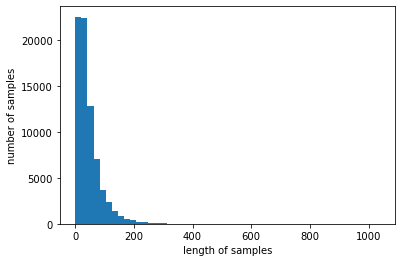

In [6]:
print(f'리뷰의 최대 길이: {max(len(l) for l in sequences)}')
print(f'리뷰의 평균 길이: {sum(map(len, sequences))/len(sequences)}')
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### 인덱스별 단어 표시

In [7]:
word_to_index = tokenizer.word_index
print(word_to_index)

{"'like'": 1, "'scent'": 2, "n't": 3, "'fragrance'": 4, "'smell'": 5, "'love'": 6, "'perfume'": 7, "'smells'": 8, "'get'": 9, "'sweet'": 10, "'really'": 11, "'bottle'": 12, "'would'": 13, "'skin'": 14, "'first'": 15, "'wear'": 16, "'time'": 17, "'notes'": 18, "'think'": 19, "'much'": 20, "'vanilla'": 21, "'still'": 22, "'well'": 23, "'hours'": 24, "'longevity'": 25, "'people'": 26, "'even'": 27, "'something'": 28, "'could'": 29, "'also'": 30, "'fragrances'": 31, "'day'": 32, "'great'": 33, "'say'": 34, "'note'": 35, "'way'": 36, "'strong'": 37, "'bit'": 38, "'fresh'": 39, "'wearing'": 40, "'got'": 41, "'nice'": 42, "'buy'": 43, "'feel'": 44, "'smelled'": 45, "'know'": 46, "'many'": 47, "'little'": 48, "'ve": 49, "'definitely'": 50, "'want'": 51, "'find'": 52, "'long'": 53, "'better'": 54, "'spray'": 55, "'sillage'": 56, "'beautiful'": 57, "'best'": 58, "'opening'": 59, "'try'": 60, "'quite'": 61, "'never'": 62, "'aventus'": 63, "'though'": 64, "'scents'": 65, "'dry'": 66, "'projection'

##### 빈도수 분석

In [8]:
threshold = 2
total_cnt = len(word_to_index) # 총 단어의 수
rare_cnt = 0 # 등장 빈도 수가 threshold 보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(f"등장 빈도가 {threshold}번 이하인 희귀 단어의 수: {rare_cnt}")
print(f"단어 집합(vocabulary)에서 희귀 단어의 비율: {rare_cnt / total_cnt}" )
print(f"전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {rare_freq / total_freq}")

등장 빈도가 2번 이하인 희귀 단어의 수: 44912
단어 집합(vocabulary)에서 희귀 단어의 비율: 0.552307635549762
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.013189565348140857


##### 등장 횟수 상위 50000개의 word 만 사용

In [9]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

print(sequences[:5])

[[41, 102, 175, 207, 142, 1698, 134, 83, 145, 1237, 2100, 4180, 874, 2645, 466, 105, 190, 474, 404, 111, 1313, 4301, 145, 3232, 4180, 5, 17, 41, 1604, 38, 77, 2819, 2, 184, 249, 355, 129, 1269, 120, 70, 155, 1698, 646, 27, 273, 587, 4, 45, 1272, 333, 466, 2065, 39, 120, 198, 330, 533, 276, 170, 36, 1699, 343, 421, 83, 575, 477, 324, 60, 532, 43, 185, 12], [15, 2041, 310, 3487, 642, 8, 1, 1432, 55, 1, 7, 806, 496, 161, 16, 8, 689, 3292, 57, 100, 67, 25, 161, 37, 801, 16, 168, 16, 343, 1263, 1095, 494, 7, 47, 90, 849, 12, 1388, 838, 404, 111, 60, 145, 3487, 273, 1762, 428, 215, 115, 1546, 57, 7, 155, 810, 35, 20, 350, 5, 5, 155, 1103, 70, 139, 442, 36, 20, 228, 572, 52, 11, 689, 459, 82, 1494, 73, 248, 632, 273, 67, 444, 138, 4, 405, 3487, 22, 8, 100, 19, 33, 244, 213, 101, 686, 2234, 16, 16, 252, 228, 1190, 1813, 22, 115, 46, 19, 1042, 12, 331, 6, 331, 187, 224, 621, 1686, 43, 12, 3753, 236, 17, 310, 268, 11, 1539], [7, 132, 58, 385, 133, 7, 132, 47, 26, 9, 454, 41, 102, 375, 1317, 510,

리뷰의 최대 길이: 792
리뷰의 평균 길이: 41.62160499605504


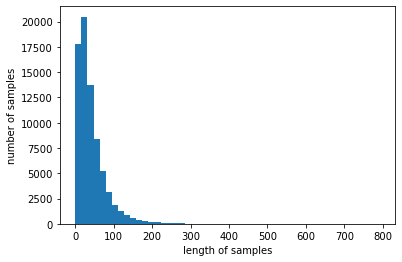

In [10]:
print(f'리뷰의 최대 길이: {max(len(l) for l in sequences)}')
print(f'리뷰의 평균 길이: {sum(map(len, sequences))/len(sequences)}')
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### Split data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(sequences, y_data)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

56084
56084
18695
18695


In [12]:
print(X_train[0])
print(y_train[0])

[446, 100, 120, 551, 39, 113, 264, 6, 187, 6, 115, 514, 157, 82, 187]
2.0


In [13]:
# padding and trimming
X_train = pad_sequences(X_train, maxlen=PAD_LEN)
X_test = pad_sequences(X_test, maxlen=PAD_LEN)

In [14]:
# One hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train[0])

[0. 0. 1. 0.]


In [15]:
model = Sequential()
model.add(Embedding(NUM_WORDS, EMBEDDING))
model.add(LSTM(EMBEDDING))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         500000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 580,804
Trainable params: 580,804
Non-trainable params: 0
_________________________________________________________________


In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('../model/lstm_with_stopword_removed_01.h5', monitor='val_acc', mode='max')

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=30, callbacks=[es, mc],
                    validation_data=(X_test, y_test))

Epoch 1/30
439/439 [==============================] - 102s 232ms/step - loss: 0.9450 - acc: 0.6187 - val_loss: 1.0471 - val_acc: 0.5840